[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_08/MISIS4825_Laboratorio08_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 08 – Taller: Redes Neuronales Convolucionales con Modelos Fundacionales

## Introducción

En este taller abordaremos el tema de las redes neuronales convolucionales (CNN) y la aplicación de **modelos fundacionales** mediante *transfer learning*. Para ello, utilizaremos el conjunto de datos **drone-bird classification** de Kaggle.

El objetivo es comparar el rendimiento de un modelo CNN entrenado desde cero con el de un modelo fundacional (por ejemplo, VGG16) adaptado a nuestra tarea de **clasificación de Drones y aves**.

## Objetivos

1. **Entrenar un modelo CNN desde cero** utilizando Keras y TensorFlow.
2. **Aplicar transfer learning** con un modelo fundacional, aprovechando características previamente aprendidas en conjuntos de datos masivos.
3. **Comparar** el rendimiento y la eficiencia de ambos enfoques.
4. **Experimentar** con distintos modelos fundacionales y diferentes configuraciones de hiperparámetros.


**Datos:** [drone-bird classification](https://www.kaggle.com/datasets/preetpalsingh25/alzheimers-dataset-4-class-of-images)

## 1. Descarga y Preparación del Dataset de Kaggle

In [1]:
from model_evaluation import evaluate_model

2025-05-01 15:38:48.063045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 15:38:48.085956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746131928.098617   68972 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746131928.102574   68972 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746131928.113255   68972 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('imbikramsaha/drone-bird-classification', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/drone-bird-classification


## 2. Exploración de Datos

Vamos a inspeccionar la carpeta que contiene las imágenes de drones y aves y crear un DataFrame con la ruta de cada imagen y su etiqueta. Luego, mostraremos cada una de las categorías y un breve conteo de cuántas imágenes hay por categoría.

Total de imágenes: 324

Número de imágenes por categoría:
label
birds     164
drones    160
Name: count, dtype: int64


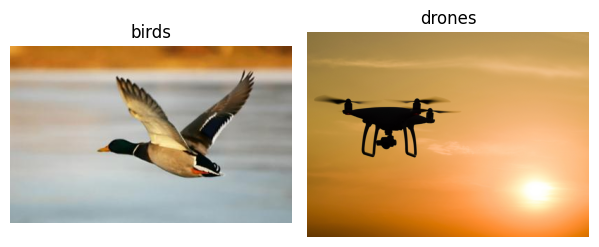

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directorio base que contiene las carpetas 'train' y 'test'
base_dir = 'data/drone_or_bird'

filepaths = []
labels = []

# Recorrer las carpetas 'train' y 'test'
for label in os.listdir(base_dir):
    label_path = os.path.join(base_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            ext = os.path.splitext(file)[1].lower()
            if ext in ['.png', '.jpg', '.jpeg']:
                filepaths.append(os.path.join(label_path, file))
                labels.append(label)

# Crear DataFrame con las rutas y etiquetas
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Mostrar conteo total y por categoría
print("Total de imágenes:", len(data_df))
print("\nNúmero de imágenes por categoría:")
print(data_df['label'].value_counts())

# Mostrar una imagen por categoría
categorias = data_df['label'].unique()
num_muestras = len(categorias)

plt.figure(figsize=(15, 10))
for i, categoria in enumerate(categorias[:num_muestras]):
    img_path = data_df[data_df['label'] == categoria].iloc[0]['filepath']
    img = mpimg.imread(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{categoria}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Preprocesamiento de Datos

Dividimos el dataset completo en tres conjuntos:
- **Entrenamiento (70%)**
- **Validación (20%)**
- **Prueba (10%)**

Esta separación nos permitirá evaluar la capacidad de generalización de nuestros modelos.

In [4]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en 70% entrenamiento y 30% (validación + prueba)
train_df, test_val_df = train_test_split(
    data_df, test_size=0.3, random_state=42, stratify=data_df['label']
)

# A partir del 30% restante, dividir en 2/3 para validación y 1/3 para prueba (~20% y ~10% del total, respectivamente)
val_df, test_df = train_test_split(
    test_val_df, test_size=(1/3), random_state=42, stratify=test_val_df['label']
)

print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Prueba:", len(test_df))


Entrenamiento: 226
Validación: 65
Prueba: 33


## 4. Generadores de Imágenes

Utilizaremos la clase `ImageDataGenerator` de Keras para:
- Reescalar los valores de píxel al rango [0, 1].
- Aplicar data augmentation (rotación, volteo horizontal) en el conjunto de entrenamiento.
- Mantener intactos los conjuntos de validación y prueba (solo reescalado).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(
    rescale=1./255
)

img_size = (128, 128)  # Compatible con la mayoría de modelos fundacionales
batch_size = 32

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

test_gen = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# Diccionario con nombre de clase -> índice
labels_map = train_gen.class_indices

# Invertimos el diccionario para tener índice -> nombre de clase
idx_to_class = {v: k for k, v in labels_map.items()}

print("\nCategorías reconocidas:")
for idx in sorted(idx_to_class):
    print(f"  Clase {idx}: '{idx_to_class[idx]}'")

num_classes = len(labels_map)
print("Número de clases:", num_classes)

Found 226 validated image filenames belonging to 2 classes.
Found 65 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.

Categorías reconocidas:
  Clase 0: 'birds'
  Clase 1: 'drones'
Número de clases: 2


## 5. Construcción del Modelo de Red Convolucional

En esta sección, definiremos una CNN desde cero (modelo *scratch*) para la clasificación de fracturas. Este modelo tendrá varias capas convolucionales y capas de pooling, seguido de capas densas para la clasificación.


In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_scratch = Sequential([
    # Primer bloque convolucional
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Segundo bloque
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Tercer bloque
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Aplanamiento y capas densas
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model_scratch.summary()

/home/pukini/.pyenv/versions/3.12.9/envs/iv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746131934.338847   68972 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,677,986 (21.66 MB)

 Trainable params: 5,677,986 (21.66 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Definición de Callbacks

Utilizamos *ModelCheckpoint* para guardar la mejor versión del modelo, *EarlyStopping* para detener el entrenamiento cuando la métrica de validación deje de mejorar y *ReduceLROnPlateau* para ajustar dinámicamente la tasa de aprendizaje.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_scratch.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_scratch = [
    ModelCheckpoint('best_model_scratch.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
]

## 7. Entrenamiento del Modelo

Entrenamos la red desde cero con los parámetros definidos anteriormente.  

In [8]:
import tensorflow as tf

epochs_scratch = 15
with tf.device('/device:GPU:0'):
    history_scratch = model_scratch.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs_scratch,
        callbacks=callbacks_scratch
    )

/home/pukini/.pyenv/versions/3.12.9/envs/iv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1746131937.015839   69403 service.cc:152] XLA service 0x754350020a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746131937.015868   69403 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-05-01 15:38:57.068127: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746131937.333707   69403 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/8 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.5000 - loss: 0.6993

I0000 00:00:1746131940.029621   69403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5462 - loss: 0.7140

2025-05-01 15:39:09.392246: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5445 - loss: 0.7128 - val_accuracy: 0.5077 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.4882 - loss: 0.6949 - val_accuracy: 0.4923 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.5830 - loss: 0.6807 - val_accuracy: 0.6308 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.5634 - loss: 0.6809 - val_accuracy: 0.5385 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - accuracy: 0.5364 - loss: 0.7764 - val_accuracy: 0.6769 - val_loss: 0.6817 - learning_rate: 0.0010
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.5426 - loss: 0.6818 - val_accuracy: 0.6000 - val_loss: 0.6735 - learning_rate: 0.0010
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.6149 - loss: 0.6693 - val_accuracy: 0.5846 - val_

## 8. Evaluación del Modelo

Visualizaremos las curvas de entrenamiento (precisión y pérdida) y cargaremos la mejor versión del modelo para evaluar en el conjunto de prueba.

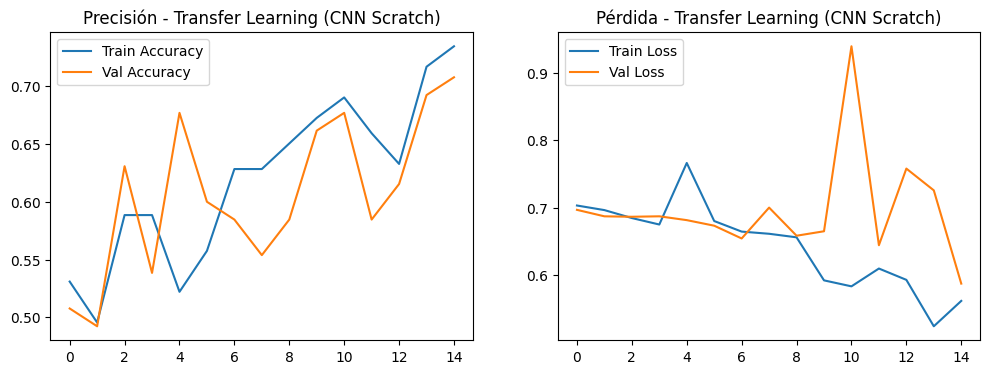

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


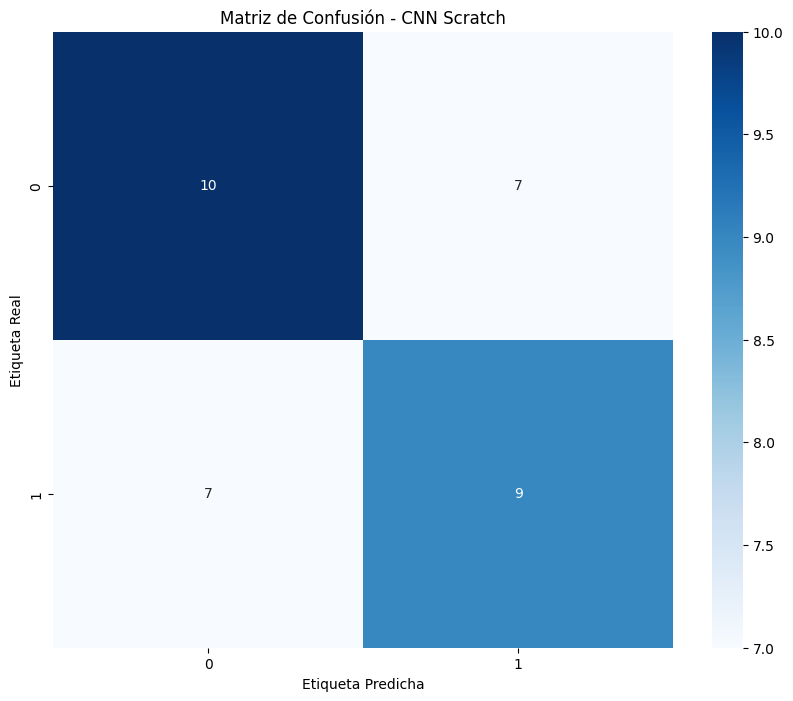

Reporte de Clasificación para CNN Scratch:
              precision    recall  f1-score   support

       birds       0.59      0.59      0.59        17
      drones       0.56      0.56      0.56        16

    accuracy                           0.58        33
   macro avg       0.58      0.58      0.58        33
weighted avg       0.58      0.58      0.58        33



In [9]:
evaluate_model('best_model_scratch.keras', test_gen, labels_map, history_scratch, 'CNN Scratch')

## 9. Transfer Learning con Modelos Fundacionales

En esta sección se aprovechará el poder de un modelo pre-entrenado, en concreto **VGG16**, para aplicar *transfer learning* en nuestra tarea de clasificación de imágenes. Utilizar un modelo como VGG16 permite:
  
- **Reducción en el tiempo de entrenamiento:** El modelo base ya ha sido entrenado en un conjunto masivo (ImageNet), lo que significa que las capas iniciales han aprendido a extraer características generales muy útiles.
- **Mejor rendimiento en datasets limitados:** Al reutilizar las representaciones aprendidas, se pueden obtener resultados competitivos incluso cuando el conjunto de datos de destino es relativamente pequeño.
  
### Sobre VGG16

VGG16 fue desarrollado por Simonyan y Zisserman en su artículo *"Very Deep Convolutional Networks for Large-Scale Image Recognition"* ([ver paper](https://arxiv.org/abs/1409.1556)). Algunas de sus características destacadas son:

- **Filtros uniformes:** Emplea filtros uniformes de 3x3 a lo largo de toda la arquitectura, lo que facilita la extracción sistemática de patrones jerárquicos a distintos niveles de abstracción.
- **Estructura profunda:** Consta de 16 capas con pesos (13 capas convolucionales y 3 capas densas), lo que permite una representación rica y detallada de las imágenes.
- **Simplicidad en el diseño:** A pesar de su profundidad, utiliza únicamente capas convolucionales con pequeños filtros y capas de pooling, lo que resulta en una arquitectura elegante y uniforme.

A continuación, se muestra un diagrama ilustrativo de la arquitectura VGG16:

![Arquitectura VGG16](https://miro.medium.com/v2/resize:fit:720/1*lXCy8RLUOtAwoS2H4ortZA.png)


### Implementación con VGG16

El siguiente bloque de código carga VGG16 sin la parte superior (la capa de clasificación final), congela sus capas para evitar su reentrenamiento, y añade una parte superior que se adapta a nuestro problema. Se entrena el modelo y se guardan las mejores versiones según la métrica de validación.

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Cargar VGG16 pre-entrenado en ImageNet, sin incluir la parte superior
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar todas las capas del modelo base para no reentrenarlas
for layer in base_model_vgg.layers:
    layer.trainable = False

# Construir el modelo de transfer learning
model_vgg = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Mostrar la arquitectura del modelo
model_vgg.summary()

# Compilar el modelo
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks para guardar el mejor modelo, detener tempranamente y reducir la tasa de aprendizaje
callbacks_vgg = [
    ModelCheckpoint('best_model_vgg.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
]

# Entrenar el modelo de transfer learning
epochs_vgg = 15
with tf.device('/device:GPU:0'):
    history_vgg = model_vgg.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs_vgg,
        callbacks=callbacks_vgg
    )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15


2025-05-01 15:39:49.189706: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 188 bytes spill stores, 188 bytes spill loads

2025-05-01 15:39:49.387611: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1413', 56 bytes spill stores, 56 bytes spill loads

2025-05-01 15:39:49.619614: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1413', 32 bytes spill stores, 32 bytes spill loads



6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5398 - loss: 0.7082

2025-05-01 15:39:57.404562: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 96 bytes spill stores, 96 bytes spill loads



7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.5489 - loss: 0.7023

2025-05-01 15:40:00.228520: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 4 bytes spill stores, 4 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5626 - loss: 0.6935 - val_accuracy: 0.6615 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.6401 - loss: 0.5851 - val_accuracy: 0.6923 - val_loss: 0.5381 - learning_rate: 0.0010
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.6993 - loss: 0.5285 - val_accuracy: 0.8462 - val_loss: 0.4490 - learning_rate: 0.0010
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.7941 - loss: 0.4742 - val_accuracy: 0.8462 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.8109 - loss: 0.4343 - val_accuracy: 0.8308 - val_loss: 0.4103 - learning_rate: 0.0010
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.8087 - loss: 0.4094 - val_accuracy: 0.8462 - val_loss: 0.3710 - learning_rate: 0.0010
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.8458 - loss: 0.3674 - val_accuracy: 0.8462 - val_

### Evaluación del Modelo

Visualizaremos las curvas de entrenamiento y evaluaremos la mejor versión del modelo en el conjunto de prueba.

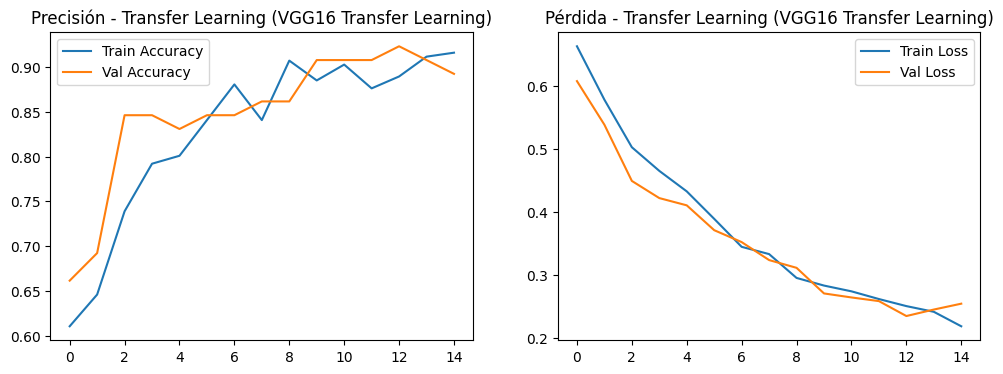

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step


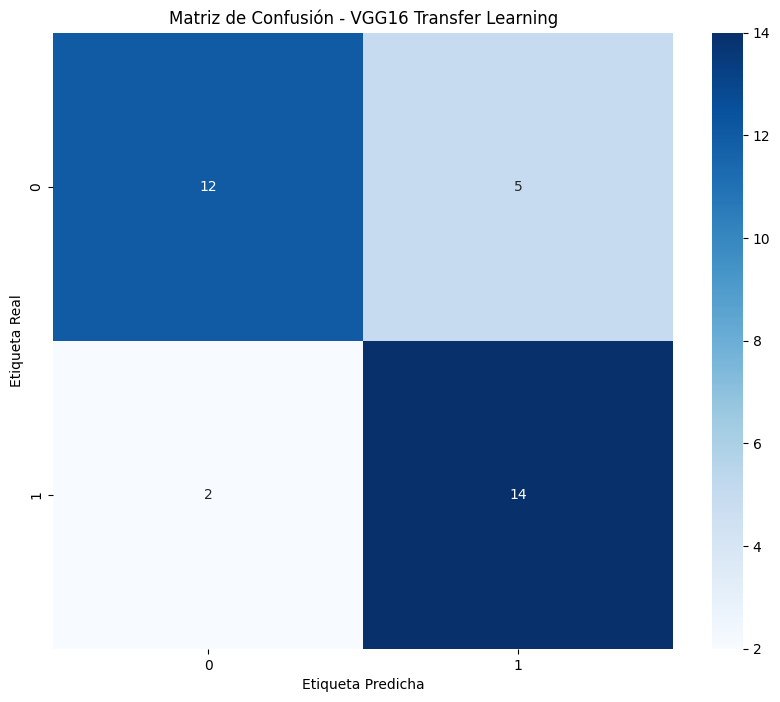

Reporte de Clasificación para VGG16 Transfer Learning:
              precision    recall  f1-score   support

       birds       0.86      0.71      0.77        17
      drones       0.74      0.88      0.80        16

    accuracy                           0.79        33
   macro avg       0.80      0.79      0.79        33
weighted avg       0.80      0.79      0.79        33



In [11]:
evaluate_model('best_model_vgg.keras', test_gen, labels_map, history_vgg, 'VGG16 Transfer Learning')

## 10. Conclusiones y Discusión

- **Comparación entre modelo Scratch y el modelo VGG16:**  
  - ¿Cuál obtuvo mejor precisión y cuál converge más rápido?
  - ¿Fue necesario más tiempo para entrenar la red desde cero?
  - ¿Por qué la arquitectura pre-entrenada podría ofrecer ventajas cuando el dataset de destino no es enorme?

- **Experimentación con Otros Modelos Fundacionales:**  
  1. Probar otras arquitecturas, como SqueezeNet, MobileNetV2, ResNet50, InceptionV3 o cualquiera de su elección.
  2. Ajustar hiperparámetros (tasa de aprendizaje, batch size, número de capas entrenables, etc.).
  3. Comparar los resultados y analizar por qué ciertos modelos pueden resultar más efectivos en este tipo de problema.

# **Integrantes**
- Nicolas Ruiz Perez - 202123608
- Valeria Caro Ramirez - 202111040

## **Comparación entre modelo Scratch y el modelo VGG16**

- **¿Cuál obtuvo mejor precisión y cuál converge más rápido?**

     * **Mejor precisión**: El modelo VGG16 alcanzó una precisión promedio del 80%, superando significativamente al modelo Scratch, que obtuvo solo un 58%. Esto evidencia que el modelo preentrenado generaliza mejor al aprovechar características previamente aprendidas. Además, el modelo VGG16 muestra un desempeño más equilibrado, ya que sus métricas (precisión, recall y F1-score) son consistentes entre las clases, lo que indica una mayor estabilidad en la clasificación.
              

    * **Convergencia**: El modelo VGG16 converge más rápido debido a que reutiliza características preentrenadas, mientras que el modelo Scratch necesita aprender desde cero.


     * **Tabla de resultados**:
          - Birds: El modelo VGG16 muestra un desempeño significativamente mejor y equilibrado en todas las métricas en comparación con el modelo Scratch.
          - Drones: El modelo Scratch tiene un desempeño muy bajo en recall y F1-score, mientras que el modelo VGG16 mantiene métricas consistentes y altas.
     
               | **Clase**   | **Métrica**   | **Modelo Scratch** | **Modelo VGG16** |
               |-------------|---------------|---------------------|------------------|
               | **Birds**   | **Precisión** | 59%                | 86%             |
               |             | **Recall**    | 59%                | 71%             |
               |             | **F1-Score**  | 59%                | 77%             |
               | **Drones**  | **Precisión** | 56%                | 74%             |
               |             | **Recall**    | 56%                | 88%             |
               |             | **F1-Score**  | 56%                | 80%             |
    
          
          


- **¿Fue necesario más tiempo para entrenar la red desde cero?**

    - Sí, el modelo Scratch requiere más tiempo de entrenamiento porque debe ajustar todos los pesos desde cero, mientras que el modelo VGG16 solo entrena las capas superiores, lo que reduce significativamente el tiempo de entrenamiento.

- **¿Por qué la arquitectura preentrenada podría ofrecer ventajas cuando el dataset de destino no es enorme?**

    - **Características Generales Aprendidas**: El modelo VGG16 ha sido previamente entrenado en un conjunto de datos masivo como ImageNet, lo que le permite extraer características generales y robustas. Estas características pueden ser reutilizadas y adaptadas eficientemente a tareas específicas, incluso cuando el dataset de destino es limitado en tamaño.

    - **Reducción del Riesgo de Sobreajuste**: Al congelar las capas inferiores del modelo preentrenado, se evita que el modelo ajuste excesivamente los pesos a los datos del conjunto pequeño, lo que reduce significativamente el riesgo de sobreajuste y mejora la capacidad de generalización.

    - **Eficiencia en Recursos y Tiempo**: Los modelos preentrenados requieren menos datos y tiempo para alcanzar un rendimiento competitivo, ya que solo es necesario entrenar las capas superiores específicas de la tarea. Esto resulta en un proceso de entrenamiento más eficiente y rápido en comparación con entrenar un modelo desde cero.

## **Experimentación con Otros Modelos Fundacionales:**  

### **InceptionV3**

![image](https://www.researchgate.net/profile/Orlando-Iparraguirre-Villanueva-2/publication/364173580/figure/fig3/AS:11431281088122319@1664977637023/Architecture-of-Inception-v3.png)

Inception v3 se centra en reducir el consumo computacional al optimizar las arquitecturas previas de Inception. Propuesto en el artículo "Rethinking the Inception Architecture for Computer Vision" (2015), coautorado por Christian Szegedy y otros, Inception v3 es más eficiente que VGGNet en términos de parámetros y costos computacionales.




La arquitectura de Inception v3 se construye progresivamente utilizando varias técnicas para optimizar la eficiencia computacional y reducir el número de parámetros. Sus principales características son:

- **Convoluciones Factorizadas**: Dividen convoluciones grandes en operaciones más pequeñas para reducir el número de parámetros y mejorar la eficiencia de la red.

- **Convoluciones Más Pequeñas**: Reemplazan convoluciones grandes (e.g., 5x5) con múltiples convoluciones más pequeñas (e.g., 3x3), lo que reduce los parámetros y acelera el entrenamiento.

- **Convoluciones Asimétricas**: Una convolución 3x3 puede ser reemplazada por una combinación de convoluciones 1x3 y 3x1, lo que reduce aún más los parámetros y mejora la eficiencia.

- **Clasificador Auxiliar**: Se inserta un pequeño clasificador CNN entre capas durante el entrenamiento. Este clasificador actúa como regularizador y su pérdida se suma a la pérdida principal de la red.

- **Reducción del Tamaño de la Malla**: Se utilizan operaciones de pooling para reducir el tamaño de las características, pero con técnicas más eficientes para evitar cuellos de botella en el costo computacional.

Referencia: https://www.digitalocean.com/community/tutorials/popular-deep-learning-architectures-resnet-inceptionv3-squeezenet

#### **Hiperparametros para el modelo**

**`learning_rate`**
- **Valores**: `[1e-4, 1e-3, 1e-2]`
- Este hiperparámetro controla la velocidad con la que el modelo ajusta los pesos durante el entrenamiento.
  - Un valor más bajo (e.g., `1e-4`) permite un ajuste más lento y preciso, pero puede requerir más tiempo para converger.
  - Un valor más alto (e.g., `1e-2`) acelera el entrenamiento, pero puede provocar que el modelo no converja correctamente.

**`dropout_rate`**
- **Valores**: `[0.2, 0.3, 0.4]`
- Este hiperparámetro especifica la proporción de neuronas que se desactivan aleatoriamente durante el entrenamiento para prevenir el sobreajuste (*overfitting*).
  - Un valor más bajo (e.g., `0.2`) aplica menos regularización.
  - Un valor más alto (e.g., `0.4`) aplica más regularización, lo que puede ser útil en modelos complejos o datasets pequeños.

**`dense_units`**
- **Valores**: `[64, 128, 256]`
- Este hiperparámetro define el número de neuronas en la capa densa (*fully connected*) después de la capa de *GlobalAveragePooling2D*.
  - Un número más bajo (e.g., `64`) reduce la capacidad del modelo para aprender características complejas, pero puede ser más rápido y menos propenso al sobreajuste.
  - Un número más alto (e.g., `256`) aumenta la capacidad del modelo para aprender características más complejas, pero puede requerir más datos y tiempo de entrenamiento.


In [17]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import ParameterSampler
import numpy as np

param_grid = {
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.2, 0.3, 0.4],
    'dense_units': [64, 128, 256],
}


n_iter = 3  
param_combinations = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

best_model = None
best_val_accuracy = 0
best_params = None

for i, params in enumerate(param_combinations):
    print(f"Running Random Search Iteration {i+1}/{n_iter} with params: {params}")
    
    base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model_inception.layers:
        layer.trainable = False

    model = Sequential([
        base_model_inception,
        GlobalAveragePooling2D(),
        Dense(params['dense_units'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


    callbacks = [
        ModelCheckpoint(f'inception/best_model_inception_{i}.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')
    ]

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate the model
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_accuracy}")

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_params = params

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Best Parameters: {best_params}")

Running Random Search Iteration 1/3 with params: {'learning_rate': 0.01, 'dropout_rate': 0.4, 'dense_units': 64}
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5068 - loss: 5.3174 - val_accuracy: 0.7846 - val_loss: 0.9004 - learning_rate: 0.0100
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - accuracy: 0.6893 - loss: 3.0293 - val_accuracy: 0.8923 - val_loss: 0.4204 - learning_rate: 0.0100
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.8977 - loss: 0.2804 - val_accuracy: 0.9077 - val_loss: 0.3119 - learning_rate: 0.0100
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - accuracy: 0.8648 - loss: 0.3458 - val_accuracy: 0.9231 - val_loss: 0.1940 - learning_rate: 0.0100
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.8820 - loss: 0.2259 - val_accuracy: 0.8769 - val_loss: 0.2609 - learning_rate: 0.0100
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.8896 - loss: 0.2479 - val_accuracy: 0.8769 - val_loss: 0.2973 - learning_ra

### **Modelo InceptionV3 - Validation Accuracy: 96%**

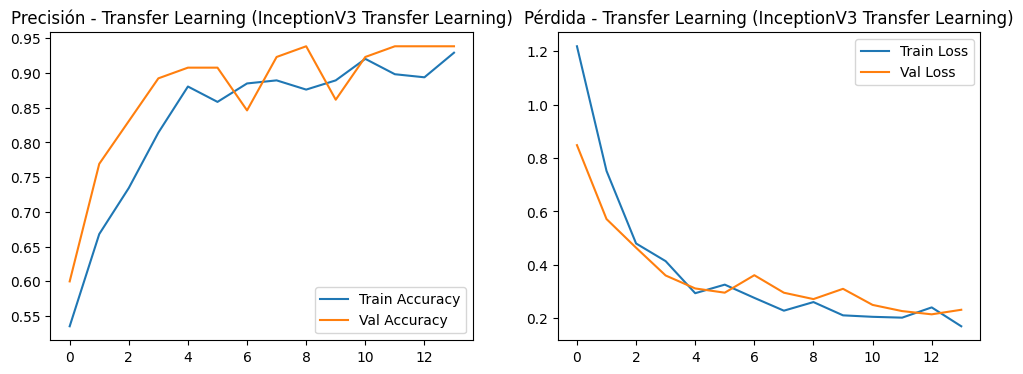

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


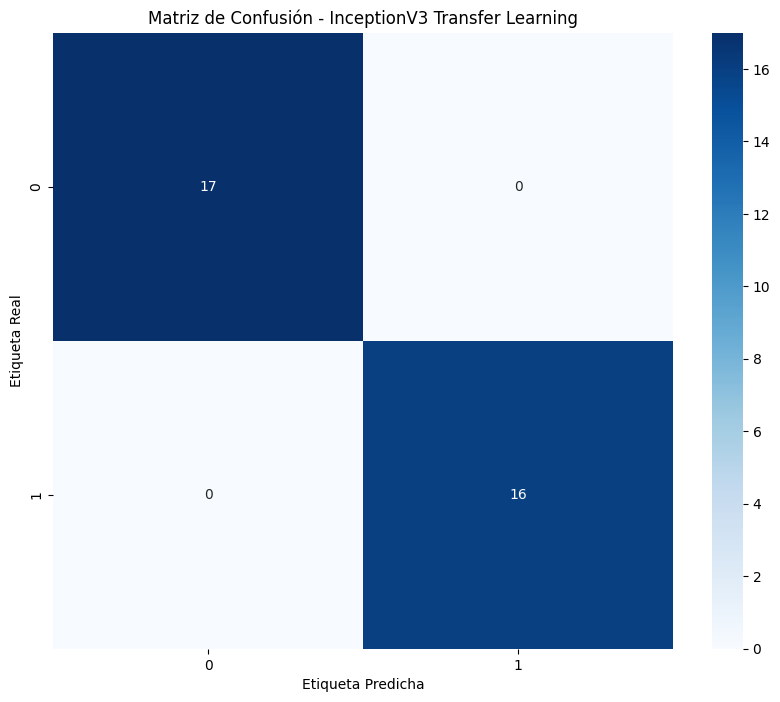

Reporte de Clasificación para InceptionV3 Transfer Learning:
              precision    recall  f1-score   support

       birds       1.00      1.00      1.00        17
      drones       1.00      1.00      1.00        16

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [21]:
evaluate_model('inception/best_model_inception_1.keras', test_gen, labels_map, history, 'InceptionV3 Transfer Learning')

### **Modelo InceptionV3 - Validation Accuracy: 93%**

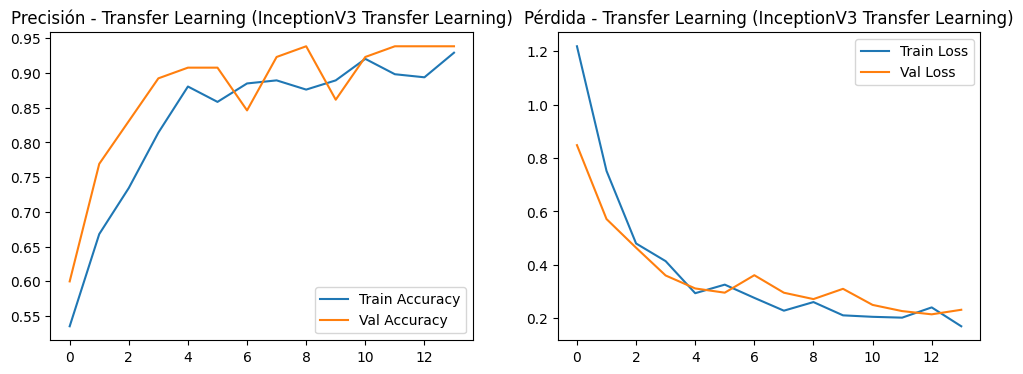

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


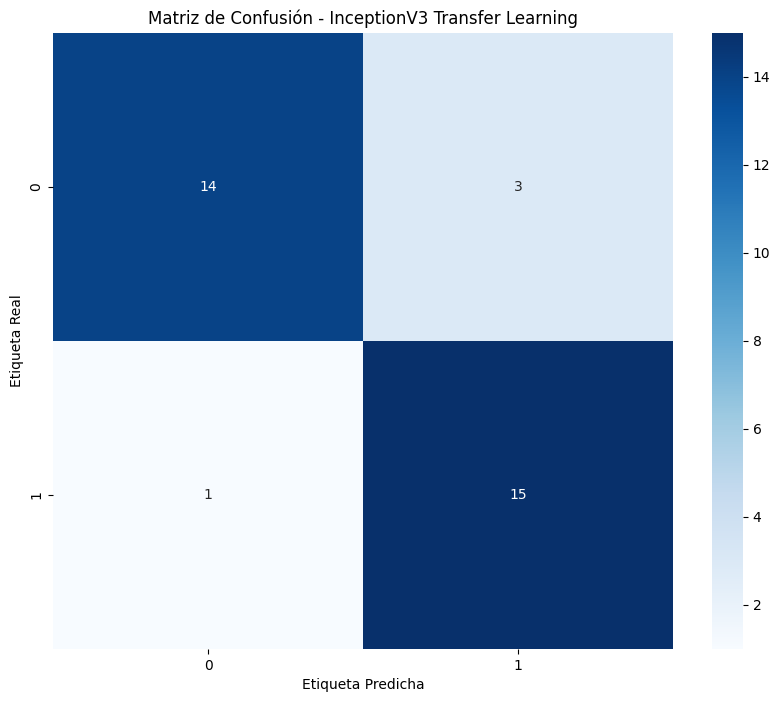

Reporte de Clasificación para InceptionV3 Transfer Learning:
              precision    recall  f1-score   support

       birds       0.93      0.82      0.88        17
      drones       0.83      0.94      0.88        16

    accuracy                           0.88        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.88      0.88      0.88        33



In [22]:
evaluate_model(f'inception/best_model_inception_2.keras', test_gen, labels_map, history, 'InceptionV3 Transfer Learning')

### **ResNet50**

![image](https://miro.medium.com/v2/resize:fit:1400/0*9LqUp7XyEx1QNc6A.png)

ResNet50 es una arquitectura de red neuronal convolucional profunda (CNN) desarrollada por Microsoft Research en 2015. Es una variante de la popular arquitectura ResNet, que significa "Red Residual".

La arquitectura completa de ResNet50 se compone de cuatro partes principales:

- **Capas de Convolución**:
    Estas capas son fundamentales para la extracción de características. Aplican filtros a las imágenes de entrada, permitiendo al modelo detectar patrones, bordes y texturas en los datos.

- **Bloques de Convolución**:
    Están formados por múltiples capas de convolución, seguidas de funciones de normalización y activación. Facilitan la extracción de características de alto nivel a partir de los datos de entrada.

- **Bloques Residuales**:
    Actúan como atajos o conexiones de salto que permiten al modelo omitir una o más capas. Esto ayuda a mitigar el problema del gradiente que se desvanece durante el entrenamiento y facilita el flujo de información.

- **Capas Completamente Conectadas**:
    Son responsables de realizar predicciones basadas en las características extraídas. En ResNet, estas capas mapean las características aprendidas a las clases de salida finales.

Referencia: https://wandb.ai/mostafaibrahim17/ml-articles/reports/The-Basics-of-ResNet50---Vmlldzo2NDkwNDE2

#### **Hiperparametros para el modelo**

**`learning_rate`**
- **Valores**: `[1e-4, 1e-3, 1e-2]`
- Este hiperparámetro controla la velocidad con la que el modelo ajusta los pesos durante el entrenamiento.
  - Un valor más bajo (e.g., `1e-4`) permite un ajuste más lento y preciso, pero puede requerir más tiempo para converger.
  - Un valor más alto (e.g., `1e-2`) acelera el entrenamiento, pero puede provocar que el modelo no converja correctamente.

**`dropout_rate`**
- **Valores**: `[0.2, 0.3, 0.4]`
- Este hiperparámetro especifica la proporción de neuronas que se desactivan aleatoriamente durante el entrenamiento para prevenir el sobreajuste (*overfitting*).
  - Un valor más bajo (e.g., `0.2`) aplica menos regularización.
  - Un valor más alto (e.g., `0.4`) aplica más regularización, lo que puede ser útil en modelos complejos o datasets pequeños.

**`dense_units`**
- **Valores**: `[64, 128, 256]`
- Este hiperparámetro define el número de neuronas en la capa densa (*fully connected*) después de la capa de *GlobalAveragePooling2D*.
  - Un número más bajo (e.g., `64`) reduce la capacidad del modelo para aprender características complejas, pero puede ser más rápido y menos propenso al sobreajuste.
  - Un número más alto (e.g., `256`) aumenta la capacidad del modelo para aprender características más complejas, pero puede requerir más datos y tiempo de entrenamiento.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import ParameterSampler


param_grid = {
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.2, 0.3, 0.4],
    'dense_units': [64, 128, 256],
}

n_iter = 3  
param_combinations = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

best_model = None
best_val_accuracy = 0
best_params = None

for i, params in enumerate(param_combinations):
    print(f"Running Random Search Iteration {i+1}/{n_iter} with params: {params}")
    
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model_resnet.layers:
        layer.trainable = False 
    
    # Construir el modelo
    model = Sequential([
        base_model_resnet,
        GlobalAveragePooling2D(),
        Dense(params['dense_units'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    callbacks = [
        ModelCheckpoint(f'resnet50/best_model_resnet50_{i}.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')
    ]
    

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=callbacks,
        verbose=1
    )
    

    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_accuracy}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_params = params

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Best Parameters: {best_params}")

Running Random Search Iteration 1/3 with params: {'learning_rate': 0.01, 'dropout_rate': 0.4, 'dense_units': 64}
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4760 - loss: 1.0484 - val_accuracy: 0.5077 - val_loss: 0.8352 - learning_rate: 0.0100
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.4798 - loss: 0.8020 - val_accuracy: 0.5385 - val_loss: 0.6882 - learning_rate: 0.0100
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.5276 - loss: 0.6988 - val_accuracy: 0.5077 - val_loss: 0.6990 - learning_rate: 0.0100
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.5458 - loss: 0.6824 - val_accuracy: 0.5385 - val_loss: 0.6925 - learning_rate: 0.0100
Epoch 5/15
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.4638 - loss: 0.6891
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.4689 - loss: 0.6896 - val_accuracy: 0.4923 - val_loss: 0.6938 - learning_rat

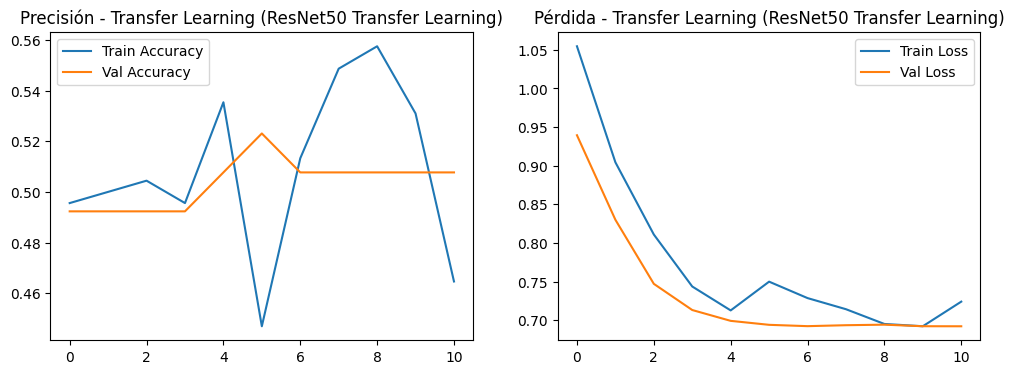

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


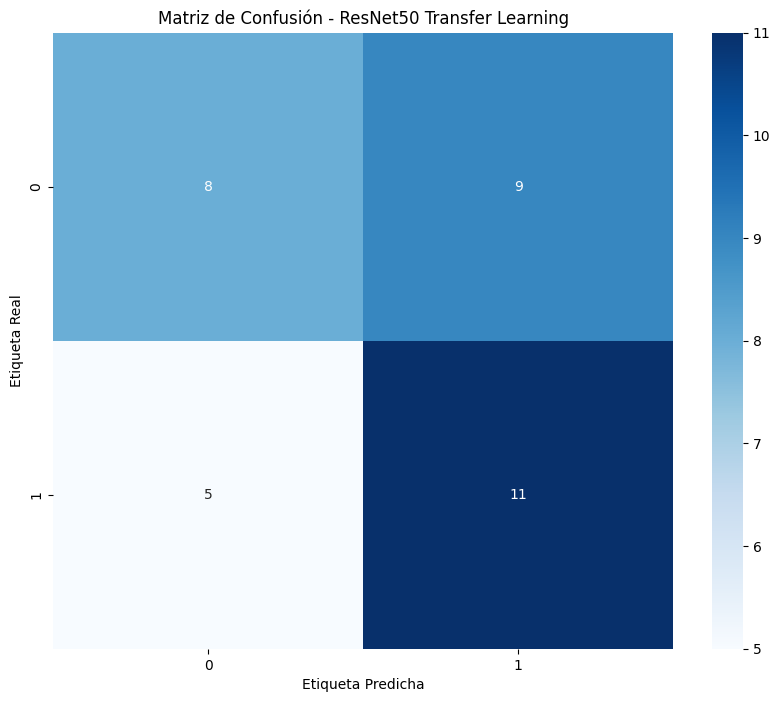

Reporte de Clasificación para ResNet50 Transfer Learning:
              precision    recall  f1-score   support

       birds       0.62      0.47      0.53        17
      drones       0.55      0.69      0.61        16

    accuracy                           0.58        33
   macro avg       0.58      0.58      0.57        33
weighted avg       0.58      0.58      0.57        33



In [25]:
evaluate_model('resnet50/best_model_resnet50_1.keras', test_gen, labels_map, history, 'ResNet50 Transfer Learning')

### **Comparación de resultados entre modelos (Scratch, VGG16, InceptionV3, ResNet50)**

#### **Resumen de resultados**

| **Clase**   | **Métrica**   | **Modelo Scratch** | **Modelo VGG16** | **Modelo InceptionV3** | **Modelo ResNet50** |
|-------------|---------------|---------------------|------------------|-------------------------|---------------------|
| **Birds**   | **Precisión** | 59%                | 86%             | 100%                   | 62%                |
|             | **Recall**    | 59%                | 71%             | 100%                   | 47%                |
|             | **F1-Score**  | 59%                | 77%             | 100%                   | 53%                |
| **Drones**  | **Precisión** | 56%                | 74%             | 100%                   | 55%                |
|             | **Recall**    | 56%                | 88%             | 100%                   | 69%                |
|             | **F1-Score**  | 56%                | 80%             | 100%                   | 61%                |
| **General** | **Accuracy**  | 58%                | 79%             | 100%                   | 58%                |

El análisis de los resultados muestra que el modelo Scratch tiene el desempeño más bajo en todas las métricas, debido a que debe aprender desde cero, lo que limita su capacidad de generalización y requiere mayor tiempo de entrenamiento. En contraste, el modelo VGG16 presenta una mejora significativa, especialmente en precisión y F1-Score, gracias al uso de características preentrenadas que permiten una mejor generalización con menos datos. Por otro lado, el modelo InceptionV3 destaca como el mejor, alcanzando un 100% en todas las métricas, gracias a su arquitectura optimizada para la eficiencia computacional y la extracción de características complejas. Finalmente, el modelo ResNet50 muestra resultados mixtos, con un desempeño inferior al de VGG16 e InceptionV3, ya que, aunque utiliza bloques residuales para mitigar problemas de gradiente, no logra superar a los otros modelos preentrenados en este caso.

Esto podría deberse a que modelos como ResNet50 no están completamente optimizados para este tipo de problema específico. Aunque ResNet50 utiliza bloques residuales para mitigar problemas como el gradiente que se desvanece, su arquitectura puede no ajustarse de manera óptima a los datos disponibles, lo que resulta en un desempeño deficiente. Además, la eficiencia computacional del modelo podría limitar su capacidad para extraer características relevantes en comparación con arquitecturas más optimizadas como VGG16 e InceptionV3, que están diseñadas para maximizar la extracción de características y la eficiencia en tareas de clasificación.

Finalmente, el modelo que obtuvo los mejores resultados fue InceptionV3, alcanzando los valores más altos de validation accuracy al probar diferentes configuraciones de hiperparámetros. En particular, se lograron precisiones del 93% y 96%, lo que demuestra que la arquitectura de este modelo se adapta de manera excepcional a los datos proporcionados. Esto maximiza su capacidad de generalización y eficiencia en la tarea de clasificación. No obstante, aunque los resultados son sobresalientes, es importante considerar la posibilidad de un ligero sobreajuste, dado el alto rendimiento obtenido en el conjunto de validación.

